In [1]:
import pandas as pd
import json
import numpy as np

import joblib

pd.set_option('display.max_colwidth',  None)

with open('result.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

df.fillna(0, inplace=True)
df = df.apply(lambda series: pd.to_numeric(series, errors='coerce'))
df = df.dropna()
df.head()

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,24.400000,46.0,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,53.0,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,31.228669,34.0,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,35.812133,28.0,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,61.0,41.13,3.67


In [2]:
del df["EEW"]
# del df["nonilfenol"]
# del df["etanol"]
del df["AHEW"]
df.head()

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,APU-4,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0,0,46.0,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0,0,53.0,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0,0,34.0,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0,0,28.0,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0,0,61.0,41.13,3.67


In [3]:


from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader


dataset = torch.FloatTensor(df.iloc[:, -3:].values)
ss = StandardScaler().fit(dataset)
dataset = ss.transform(dataset)

loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [43]:


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 6)  # Output size needs to be twice the size of your latent space (for mean and variance)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Sigmoid()  # Use sigmoid if your data is normalized between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)  # Split your hidden state into mean and variance components
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var


# Instantiate the model
model = VAE()

# Create your optimizer
optimizer = Adam(model.parameters(), lr=1e-4)

# Loss function
def vae_loss(x_reconstructed, x, mu, log_var):
    reconstruction_loss = nn.functional.l1_loss(x_reconstructed, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence


# Training loop
def train(model, data_loader, epochs=50):
    model.train()
    for epoch in range(epochs):
        for batch in data_loader:
            batch = batch.float() # Ensuring your data is of the correct dtype
            optimizer.zero_grad()
            x_reconstructed, mu, log_var = model(batch)
            loss = vae_loss(x_reconstructed, batch, mu, log_var)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

# Assuming your data is a PyTorch DataLoader
train(model, loader, epochs=1000)


Epoch: 1, Loss: 36.445194244384766
Epoch: 2, Loss: 19.123098373413086
Epoch: 3, Loss: 27.429000854492188
Epoch: 4, Loss: 17.854982376098633
Epoch: 5, Loss: 25.77815055847168
Epoch: 6, Loss: 17.520448684692383
Epoch: 7, Loss: 19.306396484375
Epoch: 8, Loss: 30.690139770507812
Epoch: 9, Loss: 15.989909172058105
Epoch: 10, Loss: 20.901887893676758
Epoch: 11, Loss: 24.823360443115234
Epoch: 12, Loss: 19.841588973999023
Epoch: 13, Loss: 15.126029014587402
Epoch: 14, Loss: 17.507604598999023
Epoch: 15, Loss: 13.709592819213867
Epoch: 16, Loss: 15.726800918579102
Epoch: 17, Loss: 19.573524475097656
Epoch: 18, Loss: 15.9361572265625
Epoch: 19, Loss: 11.2841796875
Epoch: 20, Loss: 20.508216857910156
Epoch: 21, Loss: 14.140878677368164
Epoch: 22, Loss: 15.234188079833984
Epoch: 23, Loss: 14.71925163269043
Epoch: 24, Loss: 11.461821556091309
Epoch: 25, Loss: 12.219651222229004
Epoch: 26, Loss: 18.175691604614258
Epoch: 27, Loss: 20.780494689941406
Epoch: 28, Loss: 14.114869117736816
Epoch: 29, Lo

In [56]:
model.eval()
with torch.no_grad():
    z = torch.randn(1, 3)  # Generate a random latent vector
    synthetic_data = model.decoder(z)  # Decode the latent vector into a synthetic data point
print(ss.inverse_transform(synthetic_data))

[[33.64820068 65.58874538  4.8379227 ]]


# GAN

In [1]:
import pandas as pd
import json
import numpy as np

import joblib

pd.set_option('display.max_colwidth',  None)

with open('result.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

df.fillna(0, inplace=True)
df = df.apply(lambda series: pd.to_numeric(series, errors='coerce'))
df = df.dropna()
df.head()

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,trisDMP,DCH-99,MXDA,Ethacure 100,nonilfenol,etanol,AHEW,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,24.400000,46.0,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,53.0,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,31.228669,34.0,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,35.812133,28.0,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0,0,27.685325,61.0,41.13,3.67


In [2]:
del df["EEW"]
del df["nonilfenol"]
del df["etanol"]
del df["AHEW"]
df.head()

,Epidian 6D,Araldite GY260,Araldite GY250CH,CHS-520 (*CHS-530),CHS-525,CHS-590,Epidian 5,Epidian 6,Epilox AF 18-50,AH-24/Grilonit epoxide 8,...,TEA/,Dytek A-MPMD/APU-2**,APU-4,trisDMP,DCH-99,MXDA,Ethacure 100,Fazékidő (min),Szakítószilárdság [MPa],Szakadási nyúlás [%]
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,82.57,5.58
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,41.72,3.35
2,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,56.60,4.76
3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,61.23,5.59
4,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,41.13,3.67


In [116]:
import torch
import torch.nn as nn
from torch import autograd
from torch.autograd import Variable


class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, 1),
        )

    def forward(self, x):
        return self.fc(x)

def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.Tensor(np.random.random((real_samples.size(0), 1))).to(DEVICE)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(torch.Tensor(real_samples.shape[0], 1).to(DEVICE).fill_(1.0), requires_grad=False)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [135]:


from sklearn.preprocessing import StandardScaler
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PARAMETERS = 3
Z_DIM = 100
BATCH_SIZE = 32
NUM_EPOCHS = 200
CRITIC_ITERATIONS = 1
LAMBDA_GP = 1
LAMBDA_MEAN = 0.5

dataset = torch.FloatTensor(df.iloc[:, -3:].values)
ss = StandardScaler().fit(dataset)
dataset = ss.transform(dataset)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize generator and discriminator
generator = Generator(input_dim=Z_DIM, output_dim=PARAMETERS).to(DEVICE)
discriminator = Discriminator(input_dim=PARAMETERS).to(DEVICE)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

Tensor = torch.FloatTensor

for epoch in range(NUM_EPOCHS):
    for batch_idx, data in enumerate(dataloader, 0):
        # real_data1 = Variable(data.type(Tensor))
        real_data = torch.tensor(df.iloc[:, -3:].values, dtype=torch.float).to(DEVICE)
        batch_size = real_data.shape[0]
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        # z = Variable(Tensor(np.random.normal(0, 1, (real_data.shape[0], 100))))

        # # Generate a batch of images
        # fake_data = generator(z)

        noise = torch.randn(batch_size, Z_DIM).to(DEVICE)
        fake = generator(noise).detach().cpu()
        fake = ss.inverse_transform(fake)
        fake_data = torch.tensor(fake, dtype=torch.float).to(DEVICE)

        # Real images
        real_validity = discriminator(real_data)
        # Fake images
        fake_validity = discriminator(fake_data)

        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_data.data, fake_data.data).to(DEVICE)

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if batch_idx % CRITIC_ITERATIONS == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_data = generator(noise)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_data)

            # Calculate the mean of the real data and the generated data
            mean_real_data = torch.mean(real_data, dim=0)
            mean_fake_data = torch.mean(fake_data, dim=0)

            # Calculate the absolute difference between the means
            mean_diff = torch.abs(mean_real_data - mean_fake_data)

            # Calculate the penalty as the mean of the absolute difference
            penalty = torch.mean(mean_diff)

            g_loss = -torch.mean(fake_validity) + LAMBDA_MEAN * penalty

            g_loss.backward()
            optimizer_G.step()

    print(
        f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                Loss D: {d_loss:.4f}, loss G: {g_loss:.4f}"
    )


Epoch [0/200] Batch 11/12                 Loss D: -13.9864, loss G: 13.4762
Epoch [1/200] Batch 11/12                 Loss D: -128.2570, loss G: 11.9365
Epoch [2/200] Batch 11/12                 Loss D: -222.2312, loss G: 18.0087
Epoch [3/200] Batch 11/12                 Loss D: -84.8377, loss G: 16.1789
Epoch [4/200] Batch 11/12                 Loss D: -57.8543, loss G: 15.2520
Epoch [5/200] Batch 11/12                 Loss D: -97.7984, loss G: 14.6323
Epoch [6/200] Batch 11/12                 Loss D: -138.5695, loss G: 13.4757
Epoch [7/200] Batch 11/12                 Loss D: 36.2070, loss G: 20.8466
Epoch [8/200] Batch 11/12                 Loss D: -6.5119, loss G: 16.4785
Epoch [9/200] Batch 11/12                 Loss D: -18.3103, loss G: 16.2390
Epoch [10/200] Batch 11/12                 Loss D: -21.2227, loss G: 16.1621
Epoch [11/200] Batch 11/12                 Loss D: -19.6769, loss G: 16.1400
Epoch [12/200] Batch 11/12                 Loss D: -20.4518, loss G: 16.1907
Epoch [1

In [149]:
z = Variable(Tensor(np.random.normal(0, 1, (1, 100)))).to(DEVICE)

# Generate a batch of images
fake_data = generator(z).detach().cpu()
ss.inverse_transform(fake_data)


array([[50.05075812, 65.85009241, 16.52654484]])

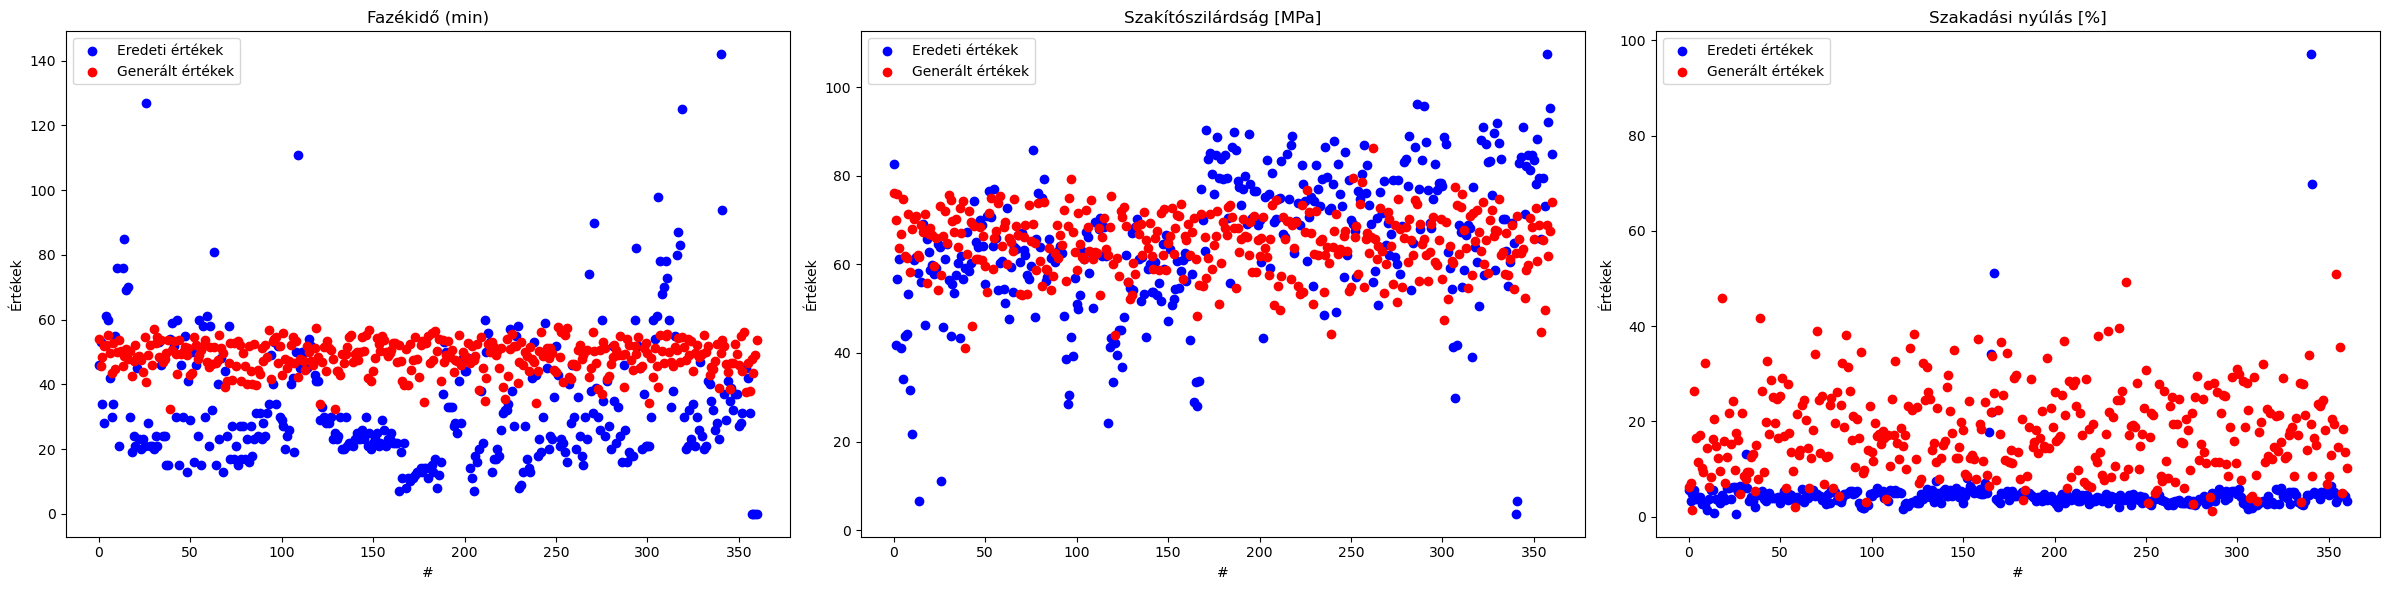

In [136]:
import matplotlib.pyplot as plt

noise = torch.randn(361, 100).to(DEVICE)
fake = generator(noise).detach().cpu()
fake = ss.inverse_transform(fake)

fake_rounded = [[round(elem, 2) for elem in inner_list] for inner_list in fake]

fake_df = pd.DataFrame(fake_rounded, columns = (['Fazékidő (min)', 'Szakítószilárdság [MPa]', 'Szakadási nyúlás [%]']))

# Assuming y_true are your true output values and y_pred are your predicted output values
y_true = df.iloc[:, -3:]
y_pred = fake_df

fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns

# Plot the actual values and the predicted values for the first feature
axs[0].scatter(range(df.shape[0]), y_true.iloc[:, 0], color='blue', label='Eredeti értékek')
axs[0].scatter(range(fake_df.shape[0]), y_pred.iloc[:, 0], color='red', label='Generált értékek')
axs[0].set_title('Fazékidő (min)')
axs[0].set_xlabel('#')
axs[0].set_ylabel('Értékek')
axs[0].legend()

# Repeat for the second feature
axs[1].scatter(range(df.shape[0]), y_true.iloc[:, 1], color='blue', label='Eredeti értékek')
axs[1].scatter(range(fake_df.shape[0]), y_pred.iloc[:, 1], color='red', label='Generált értékek')
axs[1].set_title('Szakítószilárdság [MPa]')
axs[1].set_xlabel('#')
axs[1].set_ylabel('Értékek')
axs[1].legend()

# Repeat for the third feature
axs[2].scatter(range(df.shape[0]), y_true.iloc[:, 2], color='blue', label='Eredeti értékek')
axs[2].scatter(range(fake_df.shape[0]), y_pred.iloc[:, 2], color='red', label='Generált értékek')
axs[2].set_title('Szakadási nyúlás [%]')
axs[2].set_xlabel('#')
axs[2].set_ylabel('Értékek')
axs[2].legend()

plt.tight_layout()

In [153]:
# Define the set of hyperparameters to tune
lr_G_values = [0.0002, 0.0001, 0.00005]
lr_D_values = [0.0002, 0.0001, 0.00005]
lambda_GP_values = [10, 1, 0.1]
lambda_mean_values = [1, 0.5, 0.1]

# Keep track of the best parameters and their corresponding loss
best_params = None
best_loss = float('inf')

# Perform grid search
for lr_G in lr_G_values:
    for lr_D in lr_D_values:
        for lambda_GP in lambda_GP_values:
            for lambda_mean in lambda_mean_values:
                # Initialize generator and discriminator
                generator = Generator(input_dim=Z_DIM, output_dim=PARAMETERS).to(DEVICE)
                discriminator = Discriminator(input_dim=PARAMETERS).to(DEVICE)

                # Initialize optimizers with current learning rates
                optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_G, betas=(0.5, 0.999))
                optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_D, betas=(0.5, 0.999))

                # Perform training here, using lambda_GP and lambda_mean as your gradient penalty and mean penalty
                # ...
                for epoch in range(NUM_EPOCHS):
                    for batch_idx, data in enumerate(dataloader, 0):
                        real_data = torch.tensor(df.iloc[:, -3:].values, dtype=torch.float).to(DEVICE)
                        batch_size = real_data.shape[0]

                        optimizer_D.zero_grad()

                        noise = torch.randn(batch_size, Z_DIM).to(DEVICE)
                        fake = generator(noise).detach().cpu()
                        fake = ss.inverse_transform(fake)
                        fake_data = torch.tensor(fake, dtype=torch.float).to(DEVICE)

                        real_validity = discriminator(real_data)
                        fake_validity = discriminator(fake_data)

                        gradient_penalty = compute_gradient_penalty(discriminator, real_data.data, fake_data.data).to(DEVICE)

                        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_GP * gradient_penalty

                        d_loss.backward()
                        optimizer_D.step()

                        optimizer_G.zero_grad()

                        if batch_idx % CRITIC_ITERATIONS == 0:
                            fake_data = generator(noise)
                            fake_validity = discriminator(fake_data)

                            mean_real_data = torch.mean(real_data, dim=0)
                            mean_fake_data = torch.mean(fake_data, dim=0)

                            mean_diff = torch.abs(mean_real_data - mean_fake_data)

                            penalty = torch.mean(mean_diff)

                            g_loss = -torch.mean(fake_validity) + lambda_mean * penalty

                            g_loss.backward()
                            optimizer_G.step()
                    print(
                        f"[lr_G={lr_G}, lr_D={lr_D}, lambda_GP={lambda_GP}, lambda_mean={lambda_mean}] \
                        Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                        Loss D: {d_loss:.4f}, loss G: {g_loss:.4f}"
                    )
                # Compute the validation loss or another metric to compare the models
                # This is a simplification; in practice you should use a separate validation set or some other method
                # to objectively compare the models
                val_loss = d_loss.item() + g_loss.item()

                # Update best parameters if current model is better
                if val_loss < best_loss:
                    best_params = (lr_G, lr_D, lambda_GP, lambda_mean)
                    best_loss = val_loss

# Print best parameters
print(f"Best parameters: lr_G={best_params[0]}, lr_D={best_params[1]}, lambda_GP={best_params[2]}, lambda_mean={best_params[3]}")


[lr_G=0.0002, lr_D=0.0002, lambda_GP=10, lambda_mean=1]                         Epoch [0/200] Batch 11/12                         Loss D: 8.6723, loss G: 34.3626
[lr_G=0.0002, lr_D=0.0002, lambda_GP=10, lambda_mean=1]                         Epoch [1/200] Batch 11/12                         Loss D: 8.8321, loss G: 33.7120
[lr_G=0.0002, lr_D=0.0002, lambda_GP=10, lambda_mean=1]                         Epoch [2/200] Batch 11/12                         Loss D: 8.8591, loss G: 32.6429
[lr_G=0.0002, lr_D=0.0002, lambda_GP=10, lambda_mean=1]                         Epoch [3/200] Batch 11/12                         Loss D: 8.0719, loss G: 31.0348
[lr_G=0.0002, lr_D=0.0002, lambda_GP=10, lambda_mean=1]                         Epoch [4/200] Batch 11/12                         Loss D: 4.7780, loss G: 29.4913
[lr_G=0.0002, lr_D=0.0002, lambda_GP=10, lambda_mean=1]                         Epoch [5/200] Batch 11/12                         Loss D: -1.4534, loss G: 28.1044
[lr_G=0.0002, lr_D=0.0002, 

In [154]:


from sklearn.preprocessing import StandardScaler
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PARAMETERS = 3
Z_DIM = 100
BATCH_SIZE = 32
NUM_EPOCHS = 200
CRITIC_ITERATIONS = 1
LAMBDA_GP = 10
LAMBDA_MEAN = 1

dataset = torch.FloatTensor(df.iloc[:, -3:].values)
ss = StandardScaler().fit(dataset)
dataset = ss.transform(dataset)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize generator and discriminator
generator = Generator(input_dim=Z_DIM, output_dim=PARAMETERS).to(DEVICE)
discriminator = Discriminator(input_dim=PARAMETERS).to(DEVICE)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=5e-05, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=5e-05, betas=(0.5, 0.999))

Tensor = torch.FloatTensor

for epoch in range(NUM_EPOCHS):
    for batch_idx, data in enumerate(dataloader, 0):
        # real_data1 = Variable(data.type(Tensor))
        real_data = torch.tensor(df.iloc[:, -3:].values, dtype=torch.float).to(DEVICE)
        batch_size = real_data.shape[0]
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        # z = Variable(Tensor(np.random.normal(0, 1, (real_data.shape[0], 100))))

        # # Generate a batch of images
        # fake_data = generator(z)

        noise = torch.randn(batch_size, Z_DIM).to(DEVICE)
        fake = generator(noise).detach().cpu()
        fake = ss.inverse_transform(fake)
        fake_data = torch.tensor(fake, dtype=torch.float).to(DEVICE)

        # Real images
        real_validity = discriminator(real_data)
        # Fake images
        fake_validity = discriminator(fake_data)

        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_data.data, fake_data.data).to(DEVICE)

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if batch_idx % CRITIC_ITERATIONS == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_data = generator(noise)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_data)

            # Calculate the mean of the real data and the generated data
            mean_real_data = torch.mean(real_data, dim=0)
            mean_fake_data = torch.mean(fake_data, dim=0)

            # Calculate the absolute difference between the means
            mean_diff = torch.abs(mean_real_data - mean_fake_data)

            # Calculate the penalty as the mean of the absolute difference
            penalty = torch.mean(mean_diff)

            g_loss = -torch.mean(fake_validity) + LAMBDA_MEAN * penalty

            g_loss.backward()
            optimizer_G.step()

    print(
        f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                Loss D: {d_loss:.4f}, loss G: {g_loss:.4f}"
    )


Epoch [0/200] Batch 11/12                 Loss D: 8.6695, loss G: 34.3593
Epoch [1/200] Batch 11/12                 Loss D: 8.8512, loss G: 34.2169
Epoch [2/200] Batch 11/12                 Loss D: 9.0549, loss G: 34.0531
Epoch [3/200] Batch 11/12                 Loss D: 9.2820, loss G: 33.8824
Epoch [4/200] Batch 11/12                 Loss D: 9.5410, loss G: 33.6938
Epoch [5/200] Batch 11/12                 Loss D: 9.8350, loss G: 33.4831
Epoch [6/200] Batch 11/12                 Loss D: 10.1819, loss G: 33.2383
Epoch [7/200] Batch 11/12                 Loss D: 10.5819, loss G: 32.9579
Epoch [8/200] Batch 11/12                 Loss D: 10.9983, loss G: 32.6618
Epoch [9/200] Batch 11/12                 Loss D: 11.4758, loss G: 32.3298
Epoch [10/200] Batch 11/12                 Loss D: 12.0275, loss G: 31.9108
Epoch [11/200] Batch 11/12                 Loss D: 12.5006, loss G: 31.5339
Epoch [12/200] Batch 11/12                 Loss D: 13.1221, loss G: 31.0323
Epoch [13/200] Batch 11/12  

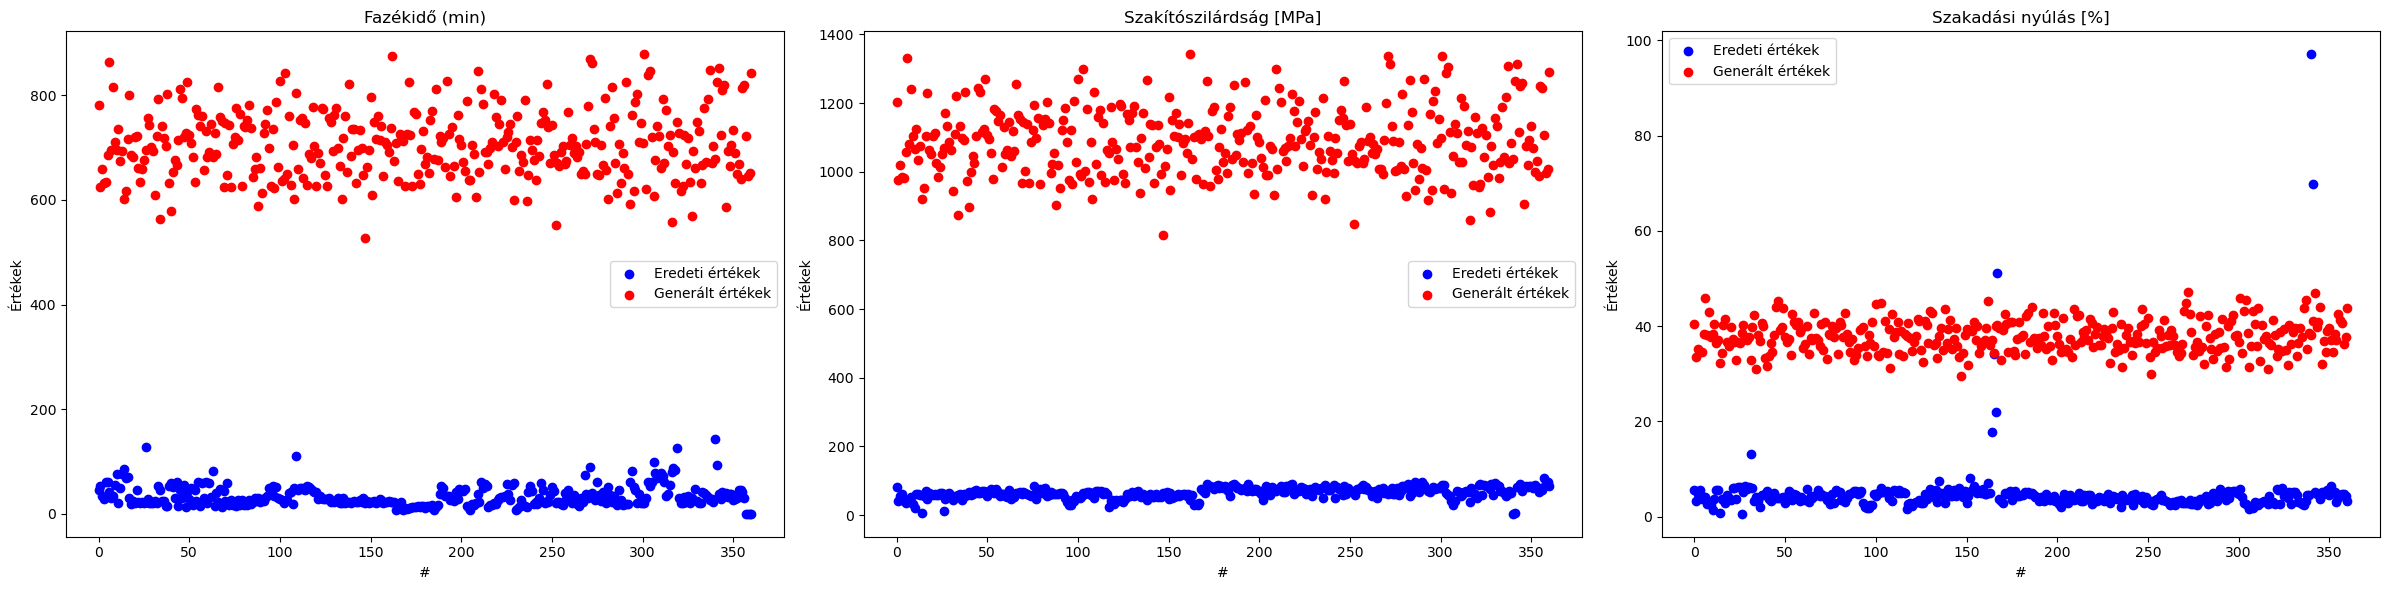

In [155]:
import matplotlib.pyplot as plt

noise = torch.randn(361, 100).to(DEVICE)
fake = generator(noise).detach().cpu()
fake = ss.inverse_transform(fake)

fake_rounded = [[round(elem, 2) for elem in inner_list] for inner_list in fake]

fake_df = pd.DataFrame(fake_rounded, columns = (['Fazékidő (min)', 'Szakítószilárdság [MPa]', 'Szakadási nyúlás [%]']))

# Assuming y_true are your true output values and y_pred are your predicted output values
y_true = df.iloc[:, -3:]
y_pred = fake_df

fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns

# Plot the actual values and the predicted values for the first feature
axs[0].scatter(range(df.shape[0]), y_true.iloc[:, 0], color='blue', label='Eredeti értékek')
axs[0].scatter(range(fake_df.shape[0]), y_pred.iloc[:, 0], color='red', label='Generált értékek')
axs[0].set_title('Fazékidő (min)')
axs[0].set_xlabel('#')
axs[0].set_ylabel('Értékek')
axs[0].legend()

# Repeat for the second feature
axs[1].scatter(range(df.shape[0]), y_true.iloc[:, 1], color='blue', label='Eredeti értékek')
axs[1].scatter(range(fake_df.shape[0]), y_pred.iloc[:, 1], color='red', label='Generált értékek')
axs[1].set_title('Szakítószilárdság [MPa]')
axs[1].set_xlabel('#')
axs[1].set_ylabel('Értékek')
axs[1].legend()

# Repeat for the third feature
axs[2].scatter(range(df.shape[0]), y_true.iloc[:, 2], color='blue', label='Eredeti értékek')
axs[2].scatter(range(fake_df.shape[0]), y_pred.iloc[:, 2], color='red', label='Generált értékek')
axs[2].set_title('Szakadási nyúlás [%]')
axs[2].set_xlabel('#')
axs[2].set_ylabel('Értékek')
axs[2].legend()

plt.tight_layout()

In [156]:
asd = df.iloc[:, -3:]
for column in asd:
    min_value = asd[column].min()
    max_value = asd[column].max()
    avg_value = asd[column].mean()
    
    print(f"For {column}:\n Min Value: {min_value}\n Max Value: {max_value}\n Average Value: {avg_value}\n")

For Fazékidő (min):
 Min Value: 0.0
 Max Value: 142.0
 Average Value: 33.64819944598338

For Szakítószilárdság [MPa]:
 Min Value: 3.7
 Max Value: 107.38
 Average Value: 65.36628808864268

For Szakadási nyúlás [%]:
 Min Value: 0.59
 Max Value: 97.06
 Average Value: 4.837922437673129

